In [1]:
import numpy as np
import matplotlib.pyplot as plt
import python_tools.voidfitter as vf
from python_tools.cosmology import Cosmology
import emcee
import corner

handle_obs = '/Volumes/BlackIce/eboss/minerva_cats/void_stats/\
redshift_redshift/\
Galaxies_HOD_*_z0.57_Redshift_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu'

handle_mocks = '/Volumes/BlackIce/eboss/minerva_cats/void_stats/\
redshift_redshift/\
Galaxies_HOD_*_z0.57_Redshift_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu'

CaiModel = vf.CaiModel(handle_obs, handle_mocks, mock_observation=True)

Setting up Cai's void RSD model.
handle_obs: /Volumes/BlackIce/eboss/minerva_cats/void_stats/redshift_redshift/Galaxies_HOD_*_z0.57_Redshift_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu
handle_mocks: /Volumes/BlackIce/eboss/minerva_cats/void_stats/redshift_redshift/Galaxies_HOD_*_z0.57_Redshift_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu
mock_observation: True


In [2]:
chain = '/Volumes/BlackIce/eboss/minerva_cats/\
void_stats/redshift_redshift/\
Galaxies_HOD_*_z0.57_Redshift_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu_emceeChain.h5'

# true values from Minerva cosmology
true_fs8 = CaiModel.fs8
true_bs8 = CaiModel.bs8
true_beta = true_fs8 / true_bs8
true_epsilon = 1

# best fit values from emcee
reader = emcee.backends.HDFBackend(chain)
flat_samples = reader.get_chain(discard=50, thin=15, flat=True)
best_beta = np.percentile(flat_samples[:, 0], 50)
best_epsilon = np.percentile(flat_samples[:, 1], 50)

print('best_beta: ' + str(best_beta))
print('true_beta: ' + str(true_beta))

print('best_epsilon: ' + str(best_epsilon))
print('true_epsilon: ' + str(true_epsilon))


# tau = reader.get_autocorr_time()
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
# samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
# log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
# log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

# print("burn-in: {0}".format(burnin))
# print("thin: {0}".format(thin))
# print("flat chain shape: {0}".format(samples.shape))
# print("flat log prob shape: {0}".format(log_prob_samples.shape))
# print("flat log prior shape: {0}".format(log_prior_samples.shape))

# Corner
#flat_samples = reader.get_chain(discard=50, thin=15, flat=True)
#fig = corner.corner(flat_samples, labels=[r"$\beta$", r"$\epsilon$"],
#            show_titles=True, quantiles=[0.16, 0.84],
#            truths=[fs8/bs8, 1.0], truth_color='r')
#fout = self.handle_obs + '_emceeCorner.png'
#print('Saving corner: ' + fout)
#plt.show()
#plt.savefig(fout)

# Quadrupole comparison: best-fit v/s true cosmology
#fig, axs = plt.subplots(2, 1, figsize=(10, 5))

best_beta: 0.502424392457316
true_beta: 0.3302974389788947
best_epsilon: 0.9846630988641141
true_epsilon: 1


Saving corner: /Volumes/BlackIce/eboss/Galaxies_HOD_*_z0.57_Redshift_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu_emceeCorner.png


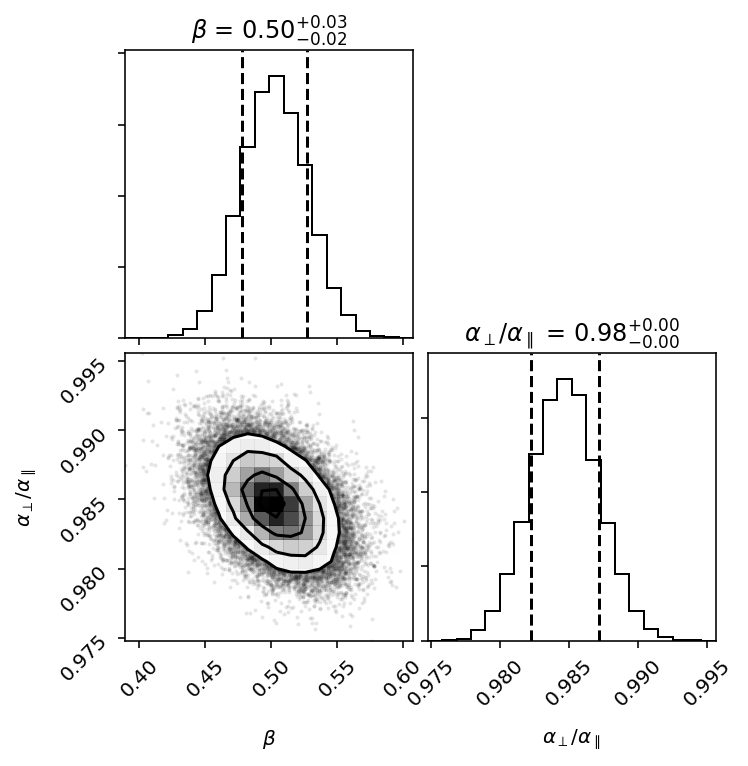

In [3]:
%config InlineBackend.figure_format='retina'
# Corner
flat_samples = reader.get_chain(discard=50, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=[r"$\beta$", r"$\alpha_{\perp} / \alpha_{\parallel}$"],
            show_titles=True, quantiles=[0.16, 0.84],
            truths=[true_beta, true_epsilon], truth_color='r')
fout = '/Volumes/BlackIce/eboss/' + CaiModel.handle_obs.split('/')[-1] + '_emceeCorner.png'
print('Saving corner: ' + fout)
plt.savefig(fout)
plt.show()

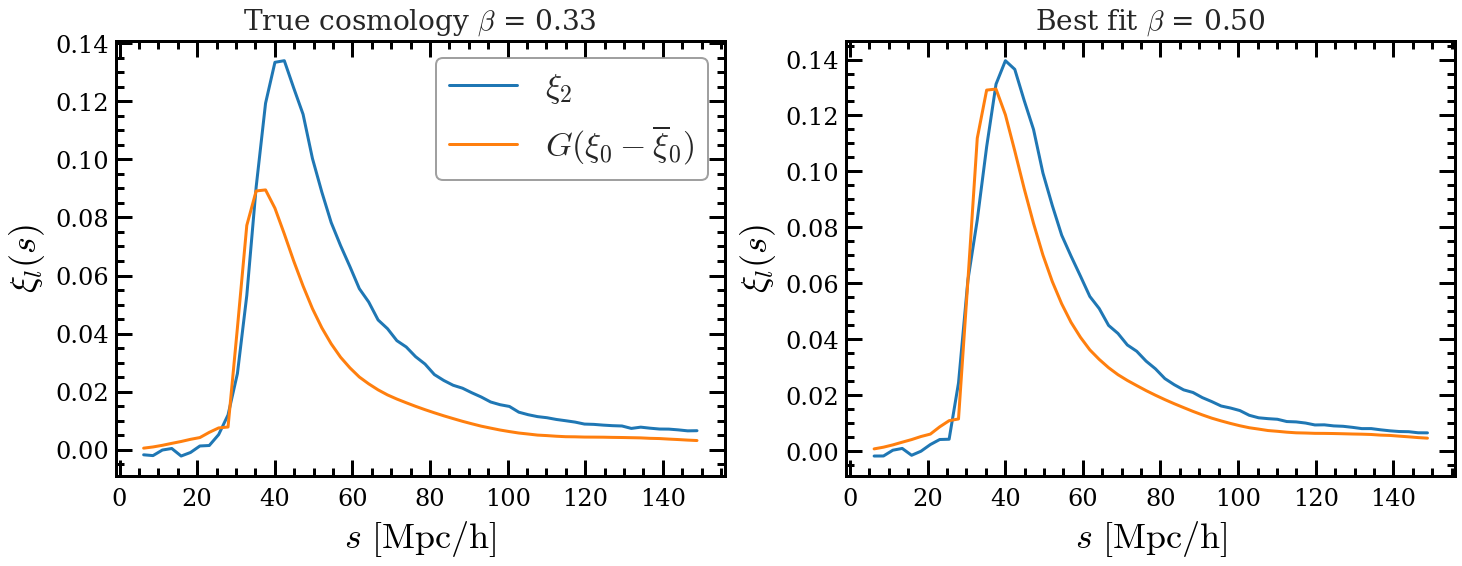

In [8]:
%matplotlib inline
plt.style.use('enrique')

fig, axs = plt.subplots(1, 2, figsize=(12,4))


s = CaiModel.s_for_xi
mu = CaiModel.mu_for_xi
epsilon = true_epsilon
beta = true_beta
alpha = 1.0
alpha_para = alpha * epsilon ** (-2/3)
alpha_perp = epsilon * alpha_para
G = 2 * beta / (3 + beta)

xi0, xibar, xi2 = CaiModel.theory_multipoles(alpha_perp, alpha_para, s, mu)
axs[0].plot(s, xi2, label=r'$\xi_2$')
axs[0].plot(s, G * (xi0 - xibar), label=r'$G (\xi_0 - \overline{\xi}_0)$')


s = CaiModel.s_for_xi
mu = CaiModel.mu_for_xi
epsilon = best_epsilon
beta = best_beta
alpha = 1.0
alpha_para = alpha * epsilon ** (-2/3)
alpha_perp = epsilon * alpha_para
G = 2 * beta / (3 + beta)

xi0, xibar, xi2 = CaiModel.theory_multipoles(alpha_perp, alpha_para, s, mu)
axs[1].plot(s, xi2, label=r'$\xi_2$')
axs[1].plot(s, G * (xi0 - xibar), label=r'$G (\xi_0 - \overline{\xi}_0)$')

for ax in axs:
    ax.set_xlabel(r'$s\ \rm{[Mpc/h]}$', fontsize=18)
    ax.set_ylabel(r'$\xi_l(s)$', fontsize=18)

axs[0].legend(loc='best', fontsize=17)
axs[0].set_title(r'True cosmology $\beta$ = {}'.format(str(true_beta)[:4]))
axs[1].set_title(r'Best fit $\beta$ = {}'.format(str(best_beta)[:4]))

fout = '/Volumes/BlackIce/eboss/' + CaiModel.handle_obs.split('/')[-1] + '_FitComparison.png'
plt.savefig(fout)
plt.show()

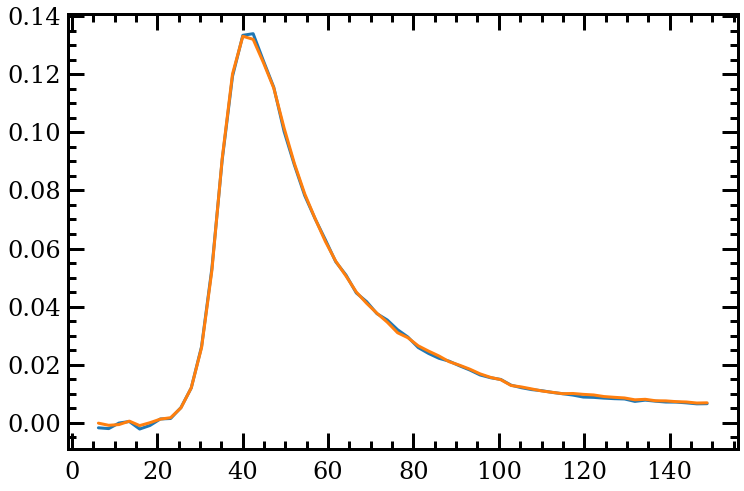

In [16]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad

fig, ax = plt.subplots(1, figsize=(6,4))

def theory_multipoles(alpha_perp, alpha_para, s, mu):

        monopole = np.zeros(len(s))
        quadrupole = np.zeros(len(s))
        true_mu = np.zeros(len(mu))
        xi_model = np.zeros(len(mu))

        for i in range(len(s)):
            for j in range(len(mu)):
                true_sperp = s[i] * np.sqrt(1 - mu[j] ** 2) * alpha_perp
                true_spar = s[i] * mu[j] * alpha_para
                true_s = np.sqrt(true_spar ** 2. + true_sperp ** 2.)
                true_mu[j] = true_spar / true_s

                xi_model[j] = CaiModel.xi_smu(true_s, true_mu[j])


            # build interpolating function for xi_smu at true_mu
            mufunc = InterpolatedUnivariateSpline(true_mu, xi_model, k=3)
            
            # get multipoles
            monopole[i] = quad(lambda xx: mufunc(xx), 0, 1, full_output=1)[0]
            quadrupole[i] = quad(lambda xx: mufunc(xx) * 5 * (3 * xx ** 2 - 1) / 2., 0, 1, full_output=1)[0]
            
        monofunc = InterpolatedUnivariateSpline(s, monopole, k=3)
            
        # cumulative monopole
        integral = np.zeros_like(s)
        for i in range(len(integral)):
            integral[i] = quad(lambda x: monofunc(x) * x ** 2, 0, s[i], full_output=1)[0]
        monopole_bar = 3 * integral / s ** 3

        return monopole, monopole_bar, quadrupole

s = CaiModel.s_for_xi
mu = CaiModel.mu_for_xi
epsilon = 1.0
alpha = 1.0
alpha_para = alpha * epsilon ** (-2/3)
alpha_perp = epsilon * alpha_para

xi0, xibar, xi2 = theory_multipoles(alpha_perp, alpha_para, s, mu)

ax.plot(s, xi2)


def theory_multipoles(alpha_perp, alpha_para, s, mu):

        monopole = np.zeros(len(s))
        quadrupole = np.zeros(len(s))
        true_mu = np.zeros(len(mu))
        xi_model = np.zeros(len(mu))

        for i in range(len(s)):
            for j in range(len(mu)):
                true_sperp = s[i] * np.sqrt(1 - mu[j] ** 2) * alpha_perp
                true_spar = s[i] * mu[j] * alpha_para
                true_s = np.sqrt(true_spar ** 2. + true_sperp ** 2.)
                true_mu[j] = true_spar / true_s

                xi_model[j] = CaiModel.xi_smu(true_s, true_mu[j])


            # build interpolating function for xi_smu at true_mu
            mufunc = InterpolatedUnivariateSpline(true_mu, xi_model, k=3)
            
            # get multipoles
            monopole[i] = quad(lambda xx: mufunc(xx) / 2, -1, 1, full_output=1)[0]
            quadrupole[i] = quad(lambda xx: mufunc(xx) * 5 / 2 * (3 * xx ** 2 - 1) / 2, -1, 1, full_output=1)[0]
            
        monofunc = InterpolatedUnivariateSpline(s, monopole, k=3)
            
        # cumulative monopole
        integral = np.zeros_like(s)
        for i in range(len(integral)):
            integral[i] = quad(lambda x: monofunc(x) * x ** 2, 0, s[i], full_output=1)[0]
        monopole_bar = 3 * integral / s ** 3

        return monopole, monopole_bar, quadrupole

s = CaiModel.s_for_xi
mu = CaiModel.mu_for_xi
epsilon = 1.0
alpha = 1.0
alpha_para = alpha * epsilon ** (-2/3)
alpha_perp = epsilon * alpha_para

xi0, xibar, xi2 = theory_multipoles(alpha_perp, alpha_para, s, mu)

ax.plot(s, xi2)



plt.show()

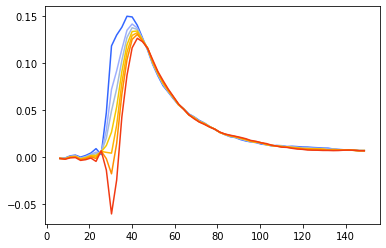

In [8]:
s = CaiModel.s_for_xi
mu = CaiModel.mu_for_xi
epsilons = [0.96, 0.98, 0.99, 1.0, 1.01, 1.02, 1.04]

fu = FigureUtilities()
colors = fu.RdYlBu[[1, 2, 3, 4, 5, 6, 7, 8]]
fig, ax = plt.subplots(1, figsize=(6,4))

for i in range(len(epsilons)):
    epsilon = epsilons[i]

    alpha = 1.0
    alpha_para = alpha * epsilon ** (-2/3)
    alpha_perp = epsilon * alpha_para

    xi0, xibar, xi2 = CaiModel.theory_multipoles(alpha_perp, alpha_para, s, mu)

    ax.plot(s, xi2, color=colors[i])
    
plt.show()

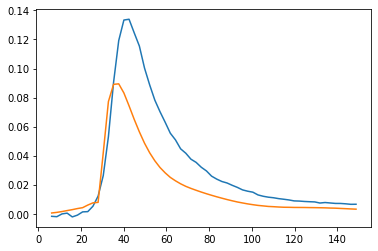

In [10]:
s = CaiModel.s_for_xi
mu = CaiModel.mu_for_xi
fu = FigureUtilities()
colors = fu.RdYlBu[[1, 2, 3, 4, 5, 6, 7, 8]]
fig, ax = plt.subplots(1, figsize=(6,4))

epsilon = 1.0

xi2 = CaiModel.get_AP_multipole(CaiModel.xi2_APSpline, epsilon)
xi0 = CaiModel.get_AP_multipole(CaiModel.xi0_APSpline, epsilon)
xibar = CaiModel.get_AP_multipole(CaiModel.xibar_APSpline, epsilon)

beta_test=CaiModel.fs8 / CaiModel.bs8
G_test = 2 * beta_test / (3 + beta_test)

ax.plot(s, xi2)
ax.plot(s, G_test * (xi0 - xibar))

plt.show()


100%|██████████| 500/500 [01:14<00:00,  6.82it/s]


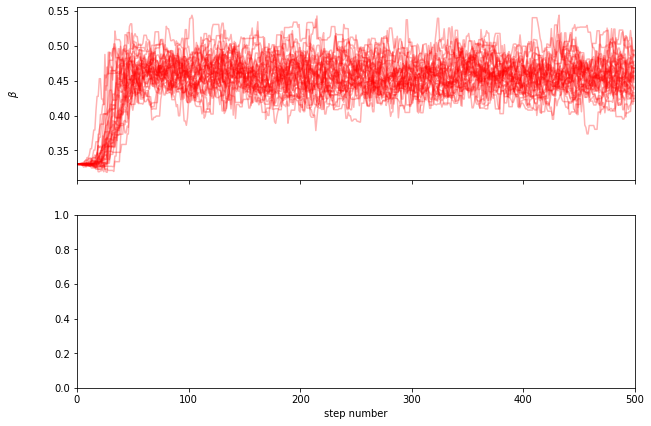

In [11]:
CaiModel.run_mcmc()

In [7]:
CaiModel.fs8 / CaiModel.bs8

0.3302974389788947